In [14]:
# %%bash
# pip install tensorflow
# pip install sklearn-pandas
# pip install matplotlib
# pip install numpy

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# from sklearn.metrics import confusion_matrix
# import itertools


In [16]:
df_test = pd.read_csv('df_test.csv', index_col='timestamp', parse_dates=True)
Df_test=df_test.copy()

df_train = pd.read_csv('df_train.csv', index_col='timestamp', parse_dates=True)
Df_train=df_train.copy()

In [17]:
sensor_names=Df_test.columns[:-2]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(Df_train[sensor_names]) # use this scaler for test and validation data set

test_scaled=scaler.transform(Df_test[sensor_names])
train_scaled=scaler.transform(Df_train[sensor_names])
pca=PCA(n_components=8).fit(train_scaled) # use this pca for test and validation data set
df_test_pca=pd.DataFrame(pca.transform(test_scaled))

pcs = ['pc'+str(i+1) for i in range(8)]
df_test_pca.columns = pcs
df_test_pca['machine_status']=Df_test['machine_status'].values
df_test_pca['alarm']=Df_test['alarm'].values
df_test_pca.index=Df_test.index
df_test=df_test_pca[['pc1','pc2','pc3','pc4','machine_status','alarm']]


In [18]:
# Generate test dataset
def generate_seq_single_preFailure(df,failure_time,features_columns,timewindow_for_use,window_len,stride):
  '''
  Generate the test data set using one machine failure time.
  '''
  
  X = np.empty((1,1,window_len*len(features_columns)), float)
  Y=np.empty((1), float)
  
  windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0]) #  mins before the failure time
  windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1]) #  mins before the failure time
  df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
  df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
  data=df_prefailure_single_window_feature.to_numpy().tolist()
  targets=df_prefailure_single_window_target.tolist()

  data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=stride,sampling_rate=1,batch_size=1,shuffle=False) # for ploting, do not shuffle the data
  
  for i in range(len(data_gen)):
    x, y = data_gen[i]
    x=np.transpose(x).flatten()
    x=x.reshape((1,1,len(x)))
    X=np.append(X,x,axis=0)
    Y=np.append(Y,y/2,axis=0)

  return X,Y



In [19]:
failure_time=df_test[df_test['machine_status']==1].index[0]
features_columns=df_test.columns.tolist()[:-2]
timewindow_for_use=(60*60,5) # 6h-5min
window_len=20
stride=1
X_test,y_test=generate_seq_single_preFailure(df_test,failure_time,features_columns,timewindow_for_use,window_len,stride)

id_keep= np.where((y_test == 0) | (y_test ==1))
y_test=y_test[id_keep]
X_test=X_test[id_keep][:,:]
X_test.shape, y_test.shape

((3576, 1, 80), (3576,))

In [20]:
model_1 = tf.keras.models.load_model("my_model.h5")


In [21]:
# evaluation1: loss and accuracy
loss,accuracy=model_1.evaluate(X_test,y_test)
print(f'Model loss on the test set: {loss:.4f}')
print(f'Model accuracy on the test set: {(accuracy*100):.2f}%')

# # evaluation2: recall
# y_test_preds_1=model_1.predict(X_test).flatten()
# y_test_preds_1=y_test_preds_1.flatten()
# y_test_preds_1=tf.round(y_test_preds_1)
# cm=confusion_matrix(y_test,tf.round(y_test_preds_1))
# recall=(cm[1,1])/(cm[1,1]+cm[1,0])
# precision=(cm[0,0])/(cm[0,1]+cm[0,0])
# print(f'Model recall on the test set: {recall:.4f}') 
# print(f'Model precison on the test set: {precision:.4f}') 


112/112 [==============================] - 1s 2ms/step - loss: 1.8019 - binary_accuracy: 0.8826
Model loss on the test set: 1.8019
Model accuracy on the test set: 88.26%


failure time: 2018-04-18 00:30:00
112/112 [==============================] - 1s 2ms/step


C:\Users\Minh Chau\AppData\Local\Temp\ipykernel_11592\1242835101.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preFailure['alarm']=np.append(np.zeros(window_len),(y_test_preds_1))


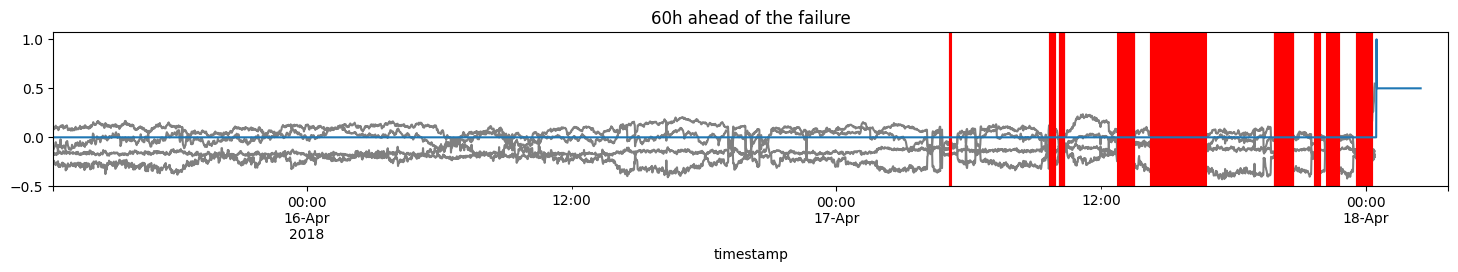

In [22]:
failure_time=df_test[df_test['machine_status']==1].index[0]
print('failure time:',failure_time)
windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0])
windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1])
df_preFailure=df_test.loc[windows_start:windows_end,:]

y_test_preds_1=model_1.predict(X_test).flatten()
y_test_preds_1=tf.round(y_test_preds_1)
df_preFailure['alarm']=np.append(np.zeros(window_len),(y_test_preds_1))

df_preFailure[['pc1','pc2','pc3','pc4']].plot(c="grey",figsize=(18,2),legend=None)
df_preFailure[df_preFailure['alarm']==1].index.to_list()

# vertical lines
for xc in df_preFailure[df_preFailure['alarm']==1].index.to_list():
  plt.axvline(x=xc,c='red')

df_test['machine_status'].plot()
plt.xlim([windows_start,windows_end+pd.Timedelta(seconds=60*200)])

plt.title("60h ahead of the failure")
plt.show()

In [23]:
%%time...

UsageError: Cell magic `%%time...` not found.
